## 11 - AndesFluxes
This notebook demonstrates how the reconstructed subduction history along the Andean margin can be potentially used in the plate kinematics anylysis and data mining. For example, there is the potential link between the overall subduction flux and zircon age frequency. Another example is that the along-strike variations on inputs to the subduction zone could relate to porphyry copper formation.

### Citation:
Seton, M., Williams, S.E., Domeier, M. et al. Deconstructing plate tectonic reconstructions. Nat Rev Earth Environ 4, 185–204 (2023). https://doi.org/10.1038/s43017-022-00384-8

In [1]:
import sys
import gplately
import numpy as np
import pygplates
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from plate_model_manager import PlateModelManager

anchor_plate_id = 0

#south_america_plate_id = 201

### PlateModelManager

The **PlateModelManager** class can be used to download the plate reconstruction model files via Internet. The files will be fetched and saved into local folders. Users can use the member functions of PlateModel class to retrieve the local absolute path of the files. For example, the get_rotation_model() will return the local path to the rotation file(s).

The **PlateReconstruction** class can be used to reconstruct tectonic plates and calculate subduction convergence stats.

The **PlotTopologies** class can be used to plot reconstruction maps.

In [2]:
%%capture cap
# Use PlateModelManager to download and manage files of the plate reconstruction models
pm_manager = PlateModelManager()
plate_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

model = gplately.PlateReconstruction(plate_model.get_rotation_model(), 
                                     plate_model.get_topologies(), 
                                     plate_model.get_static_polygons(),
                                     anchor_plate_id=anchor_plate_id)
gplot = gplately.plot.PlotTopologies(model, 
                                     plate_model.get_layer('Coastlines'), 
                                     plate_model.get_layer('ContinentalPolygons'), 
                                     plate_model.get_layer('COBs'))

### Define the function to calculate and filter subduction zone stats for South America

In [3]:
# We are only interested in the latitude -55 and 5 in this notebook. 
lat_samples = np.arange(-55,5,0.1)

def get_south_america_subduction_zone_data(r12n_time):
    """we are only interesed in the South America subduction zone in this notebook
        filter and keep the South America subduction zone data only
    
    # Calculate subduction convergence stats with GPlately
    # Col. 0 - longitude of sampled trench point
    # Col. 1 - latitude of sampled trench point
    # Col. 2 - subducting convergence (relative to trench) velocity magnitude (in cm/yr)
    # Col. 3 - subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
    # Col. 4 - trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
    # Col. 5 - trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
    # Col. 6 - length of arc segment (in degrees) that current point is on
    # Col. 7 - trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
    # Col. 8 - subducting plate ID
    # Col. 9 - trench plate ID
    """
    subduction_data = model.tessellate_subduction_zones(r12n_time, 
                                                        tessellation_threshold_radians=0.01, 
                                                        anchor_plate_id=anchor_plate_id)
      
    ret=[]
    for row in subduction_data:
        # only keep the data for South America subduction zone
        if row[8] in [902,908,919,904,911,985,224,802] and (row[9]==201 or row[9]>200000): # code copied from Simon's original notebook
            ret.append(row)
    ret.sort(key=lambda row: row[1])
    ret_df = pd.DataFrame(ret, columns=['lon', 'lat', 'conv_rate', 'conv_angle', 'trench_velocity', 'trench_velocity_angle', 'arc_length',
                                     'trench_azimuth_angle', 'subducting_pid', 'trench_pid'])
    return ret_df[(ret_df.lat>lat_samples.min()) & (ret_df.lat<lat_samples.max())]


### Plot the South America subduction zone sample points
In the cell below, we are going to plot the South America subduction zone sample points in a map. The sample points are coloured by the values of "subducting convergence (relative to trench) velocity magnitude (in cm/yr)"

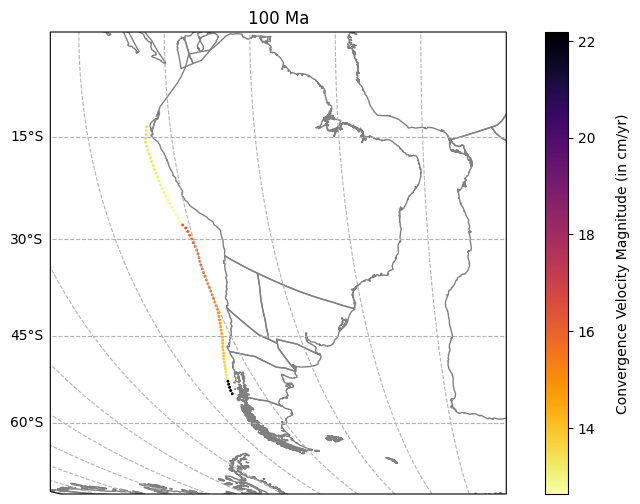

In [4]:

reconstruction_time = 100
# firstly, we get the data by calling the function defined in the above cell
south_america_subduction_data = get_south_america_subduction_zone_data(reconstruction_time)

fig = plt.figure(figsize=(10,6), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))

gl=ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
gl.left_labels = True

plt.title(f'{reconstruction_time} Ma')
# you may change the extent to global to see the sample points in a world map.
#ax.set_global()
ax.set_extent([-80,0,-70,0])

gplot.time = reconstruction_time
gplot.plot_coastlines(ax, color='grey')

# Latitudes and longitudes of points along trench segments
subduction_lon = south_america_subduction_data.lon
subduction_lat = south_america_subduction_data.lat

conv_rate = south_america_subduction_data.conv_rate # subducting convergence (relative to trench) velocity magnitude (in cm/yr)
cb=ax.scatter(subduction_lon,subduction_lat, marker=".", s=5, c=conv_rate, transform=ccrs.PlateCarree(), cmap="inferno_r")

cbar = plt.colorbar(cb)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Convergence Velocity Magnitude (in cm/yr)', rotation=90)
plt.show()

The get_extent_from_data() function is just a helper function to get the region of interest from the input data. It will return a much smaller area of the map which matters in this notebook. Then, we use the smaller area to do the "raster query". It will improve the performance dramatically.

In [5]:
def get_extent_from_data(data, extent_buffer=2):
    x0 = data.lon.min()-extent_buffer
    if x0<-180: x0=360+x0
    x1 = data.lon.max()+extent_buffer
    if x1>180: x1=x1-360
    y0 = data.lat.min()-extent_buffer
    if y0<-90: y0=180+y0
    y1 = data.lat.max()+extent_buffer
    if y1>90: y1=y1-360
    return [x0,x1,y0,y1]

### Calculate the South America subduction zone stats
We are going to calculate a few things in the code cell below.
* Subduction area flux
* Subduction volume flux
* Trench-Orthogonal convergence rate
* Seafloor age
* Thickness of subducting carbonate sediment

**Note: this code cell will take a while to run and will download a number of files from Internet.**

In [6]:
# We are only interested in the reconstruction time from 120Ma to 0Ma
time_series = np.arange(0,121,1)

area_flux_series=[]
volume_flux_series=[]
age_array = []
conv_array = []
carbonate_array = []
for time in time_series:
    sa_sub_data = get_south_america_subduction_zone_data(time)
    conv_rate = sa_sub_data.conv_rate # subducting convergence (relative to trench) velocity magnitude (in cm/yr)
    conv_obliq = sa_sub_data.conv_angle # subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
    arc_length = sa_sub_data.arc_length # length of arc segment (in degrees) that current point is on
    # Latitudes and longitudes of points along trench segments
    subduction_lon = sa_sub_data.lon
    subduction_lat = sa_sub_data.lat

    ortho_conv_rate = conv_rate*np.abs(np.cos(np.radians(conv_obliq)))
    area_flux = ortho_conv_rate * 100. * arc_length * 2 * np.pi * 6371000. / 360. # formula copied from Simon's Notebook

    #
    # Query age grid rasters
    #
    age_grid_raster = gplately.Raster(
        data=plate_model.get_raster("AgeGrids",time),
        plate_reconstruction=model,
        extent=[-180, 180, -90, 90],
    )
    age_grid_raster=age_grid_raster.clip_by_extent(get_extent_from_data(sa_sub_data))
    ages = age_grid_raster.query(subduction_lon, subduction_lat,region_of_interest=200)

    #
    # Query carbonate sediment thickness rasters
    #
    carbonate_thickness_raster = gplately.Raster(
        data=plate_model.get_raster("SedimentThickness",time),
        plate_reconstruction=model,
        extent=[-180, 180, -90, 90],
    )
    carbonate_thickness_raster=carbonate_thickness_raster.clip_by_extent(get_extent_from_data(sa_sub_data))
    carbonate_thickness = carbonate_thickness_raster.query(subduction_lon, subduction_lat,region_of_interest=200)
    
    #
    # we have two methods to get the volume flux
    #
    # method 1: use gplately.tools.plate_isotherm_depth
    # plate_depth = [gplately.tools.plate_isotherm_depth(seafloor_age) for seafloor_age in ages]
    # volume_flux = area_flux * plate_depth 
    
    # method 2: use Simon's formula
    volume_flux = area_flux * np.sqrt(ages) * 10.  # UNITS????

    area_flux_series.append(area_flux.sum())
    volume_flux_series.append(np.nansum(volume_flux))

    conv_array.append(np.interp(lat_samples, subduction_lat, ortho_conv_rate, left=np.nan, right=np.nan))
    age_array.append(np.interp(lat_samples, subduction_lat, ages, left=np.nan, right=np.nan))
    carbonate_array.append(np.interp(lat_samples, subduction_lat, carbonate_thickness, left=np.nan, right=np.nan))
    
    gplately.tools.update_progress(time/time_series.size)   

Progress: [####################] 99.2%


### plot the area flux and volume flux

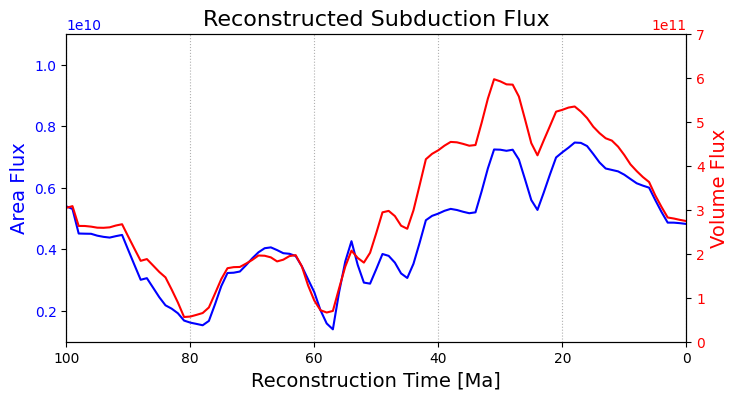

In [7]:
from scipy.ndimage import uniform_filter1d

fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

N=3
ax.plot(time_series, uniform_filter1d(area_flux_series, size=N), 'b', label='area flux')
ax.set_xlim(100,0)
ax.set_ylim(1e9,11e9)
ax.grid(axis='x', linestyle=':')
#ax.set_xticklabels([])
ax.set_ylabel('Area Flux', fontsize=14, color='b')
ax.tick_params(axis='y', labelcolor='b')

ax1 = ax.twinx() 
ax1.plot(time_series, uniform_filter1d(np.array(volume_flux_series), size=N), 'r', label='volume flux')
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax1.set_ylabel('Volume Flux', fontsize=14, color='r')
ax1.set_ylim(0e11,7e11)
ax1.tick_params(axis='y', labelcolor='r')
#ax.legend()
ax.set_title('Reconstructed Subduction Flux', fontsize=16)
plt.show()

### Plot the Trench-Orthogonal convergence rate

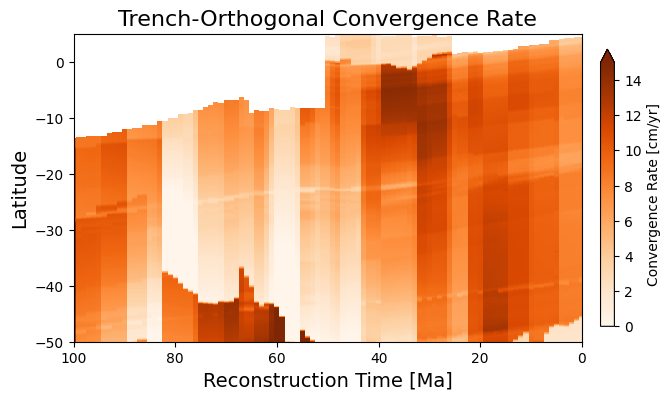

In [8]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.pcolormesh(time_series, 
               lat_samples, 
               np.array(conv_array).T, 
               vmin=0, vmax=15, cmap='Oranges')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Convergence Rate [cm/yr]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Trench-Orthogonal Convergence Rate', fontsize=16)
plt.show()


### Plot subducting seafloor age 

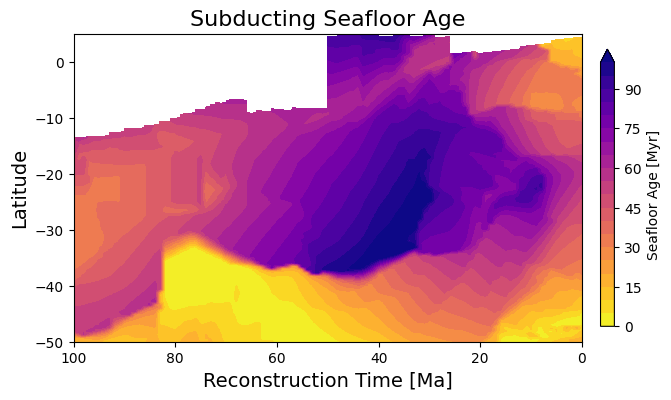

In [9]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.contourf(time_series, 
               lat_samples, 
               np.array(age_array).T, 
               levels=np.arange(0,101,5), cmap='plasma_r', extend='max')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Seafloor Age [Myr]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Subducting Seafloor Age', fontsize=16)
plt.show()

### Plot subducting carbonate sediment thickness

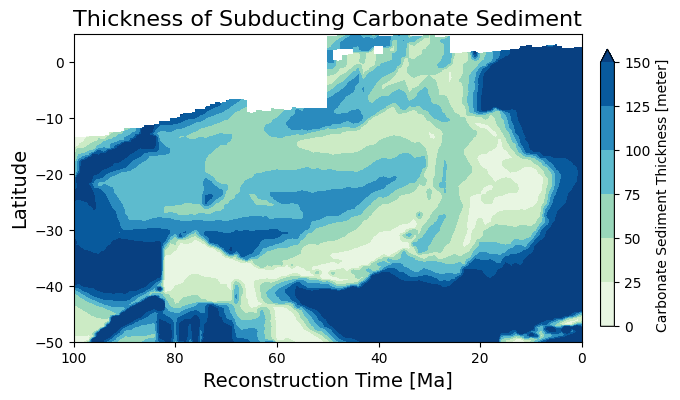

In [10]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(111)

m = ax.contourf(time_series, 
               lat_samples, 
               np.array(carbonate_array).T, 
               levels=[0,25,50,75,100,125,150], vmax=150, cmap='GnBu', extend='max')

fig.colorbar(m, orientation="vertical", extend='max', shrink=0.9, pad=0.03, label='Carbonate Sediment Thickness [meter]')

ax.set_xlim(100,0)
ax.set_ylim(-50,5)
ax.set_xlabel('Reconstruction Time [Ma]', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Thickness of Subducting Carbonate Sediment', fontsize=16)
plt.show()